In [27]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.common import *

thresh = 0.15

def get_lscale(y,Lvv):
    Ny = np.size(Lvv)
    i1 = np.argmin(abs(Lvv[:Ny/2]-thresh))
    i2 = np.argmin(abs(Lvv[Ny/2:]-thresh)) + Ny/2 
    L_int = abs(y[i1]-y[i2])
    return L_int

def get_L99(y,utilde,plotOpt=False):
    utop = 0.99*inp.du/2
    ubot = -0.99*inp.du/2
    ibot = np.argmin(abs(utilde[Ny/2:]-utop)[::-1])
    itop = np.argmin(abs(utilde[:Ny/2]-ubot)[::-1])+Ny/2
    L99 = y[itop]-y[ibot]
    if plotOpt:
        plt.plot(y,utilde)
        #plt.plot(y[:Ny/2],utilde[:Ny/2],'--')
        #plt.plot(y[Ny/2:],utilde[Ny/2:],'--')
        plt.plot([y[ibot],y[ibot]],[-inp.du/2.,inp.du/2.],'k:',label='bot')
        plt.plot([y[itop],y[itop]],[-inp.du/2.,inp.du/2.],'k--',label='top')
        plt.legend()
    return L99,itop,ibot


# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/1024x1448x512/'
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr7/1024x1448x512/'

inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

flist = glob.glob(directory+"*lscale_pp*")
flist.sort()
print([f.split('/')[-1] for f in flist])


Params for this run:
	Mc = 0.8
	Re = 1000.0
	rr = 7.0
Params for this grid:
	N = 1024x1448x512
	L = 100.0x125.0x50.0
['shearlayer_lscale_pp_0001.dat', 'shearlayer_lscale_pp_0002.dat', 'shearlayer_lscale_pp_0003.dat', 'shearlayer_lscale_pp_0004.dat', 'shearlayer_lscale_pp_0005.dat', 'shearlayer_lscale_pp_0006.dat', 'shearlayer_lscale_pp_0007.dat', 'shearlayer_lscale_pp_0008.dat', 'shearlayer_lscale_pp_0009.dat', 'shearlayer_lscale_pp_0010.dat', 'shearlayer_lscale_pp_0011.dat', 'shearlayer_lscale_pp_0012.dat', 'shearlayer_lscale_pp_0013.dat', 'shearlayer_lscale_pp_0014.dat']


21.250863856254327
/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr7/1024x1448x512/
L/L99 mean, std: [0.418523153602, 0.0916451857623]


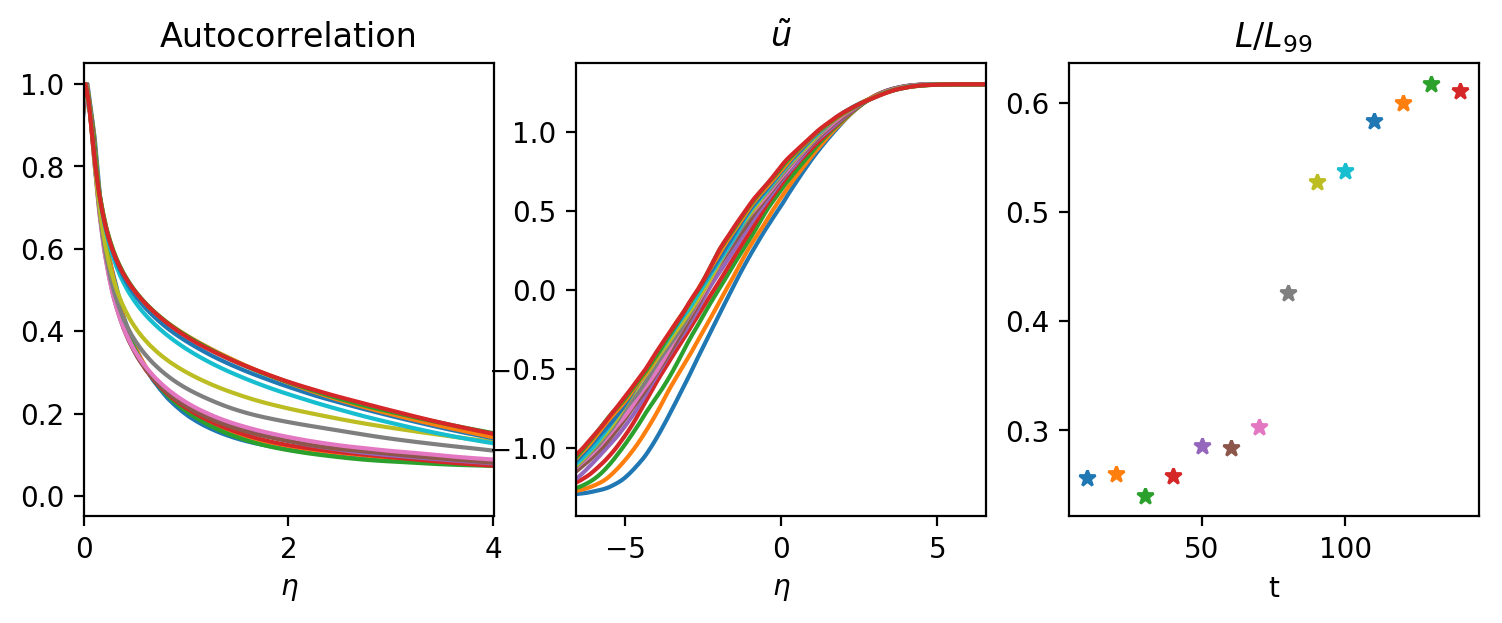

In [29]:
# vv correlation profiles
fig,ax = plt.subplots(1,3,figsize=(9,3), dpi=200)

flist_plot = flist[:]
lscales = np.zeros(len(flist_plot))
count = 0

for fname in flist_plot:
    tID = fname.split('_')[-1]
    tID = tID.split('.dat')[0]
    time = nml.read_time(directory,tID)
        
    # Get eta
    dtheta = get_dtheta(directory,time)
    eta = y/dtheta
    
    # Get integral lengthscale
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    autocorr = np.fft.fftshift(dat)
    L_int = get_lscale(y,autocorr)
    ax[0].plot(eta, autocorr, alpha=1,label='t=%d'%time)
    
    # Get 99% lengthscale
    utilde = np.fromfile( directory + 'shearlayer_utilde_'+str(tID)+'.dat',dtype=float, count=-1, sep=' ')
    L99,i1,i2 = get_L99(y,utilde)
    ax[1].plot(eta, utilde, alpha=1)
    
    ax[2].plot(time,L_int/L99,'*',label='t=%d'%time)
    
    # Record for later
    lscales[count] = L_int/L99
    count += 1

    
# ax[2].legend()
print(L_int)
ax[0].set_xlim([0.,L_int/2/dtheta])
ax[1].set_xlim([-L99/2/dtheta,L99/2/dtheta])
ax[0].set_xlabel(r'$\eta$')
ax[1].set_xlabel(r'$\eta$')
ax[2].set_xlabel('t')
ax[0].set_title('Autocorrelation')
ax[1].set_title(r'$\tilde{u}$')
ax[2].set_title('$L/L_{99}$')

istart = 6
ie = 9
print(directory)
print("L/L99 mean, std: [{}, {}]".format(np.mean(lscales[istart:ie]),np.std(lscales[istart:ie])))

fig.savefig(directory+'/img/lscale_p.png',dpi=200, bbox_inches='tight')

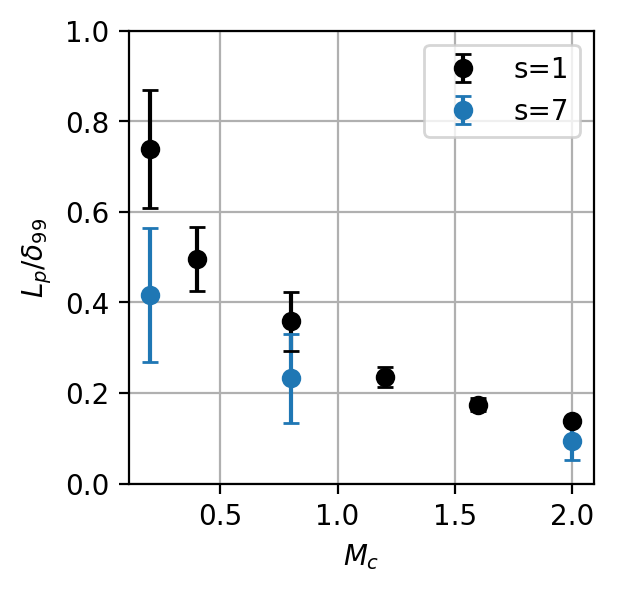

In [3]:

Lvv = {
    0.2: [0.738617711224, 0.129731413853],
    0.4: [0.495764508949, 0.0699403967942],
    0.8: [0.358575686731, 0.0654589660484],
    1.2: [0.235563316527, 0.0219876151016],
    1.6: [0.174471540562, 0.0149846508582],
    2.0: [0.13847532889, 0.00708114001304]
}
Lvv_rr7 = {
    0.2: [0.304503117466, 0.0158374469933],
    0.8: [0.247872728851, 0.0802185876213],
    2.0: [0.107811805616, 0.0299659908637] 
}
Lvv_rr_7 = {
    0.2: [0.528508769786, 0.0328115818646],
    0.8: [0.217120653774, 0.0184289268211],
    2.0: [0.0823897184338, 0.00856029204478]
}

def merge_dicts(old1,old2):
    new = {}
    for i in range(3):
        key = old1.keys()[i]
        v1 = old1.values()[i][0]
        v2 = old2.values()[i][0]
        e1 = old1.values()[i][1]
        e2 = old2.values()[i][1]
        err = np.std([v1,v2]) + (e1**2+e2**2)**0.5
        new[key] = [(v1+v2)/2., err]
    return new

rr = merge_dicts(Lvv_rr7,Lvv_rr_7)

fig = plt.figure(figsize=(3,3),dpi=200)
plt.errorbar(Lvv.keys(),[x[0] for x in Lvv.values()], yerr=[x[1] for x in Lvv.values()],fmt='ko',label='s=1',capsize=3)
# plt.errorbar([k+0.02 for k in Lvv_rr7.keys()],[x[0] for x in Lvv_rr7.values()], yerr=[x[1] for x in Lvv_rr7.values()],fmt='o',label='s=7',capsize=3)
# plt.errorbar([k-0.02 for k in Lvv_rr_7.keys()],[x[0] for x in Lvv_rr_7.values()], yerr=[x[1] for x in Lvv_rr_7.values()],fmt='o',label='s=1/7',capsize=3)
plt.errorbar(rr.keys(),[x[0] for x in rr.values()], yerr=[x[1] for x in rr.values()],fmt='o',label='s=7',capsize=3)


plt.legend()
plt.grid(True)
plt.xlabel(r'$M_c$')
plt.ylabel(r'$L_p/\delta_{99}$')
plt.ylim([0,1])
plt.savefig('/home/kmatsuno/ShearLayer_img/lscale_p.png',dpi=200, bbox_inches='tight')

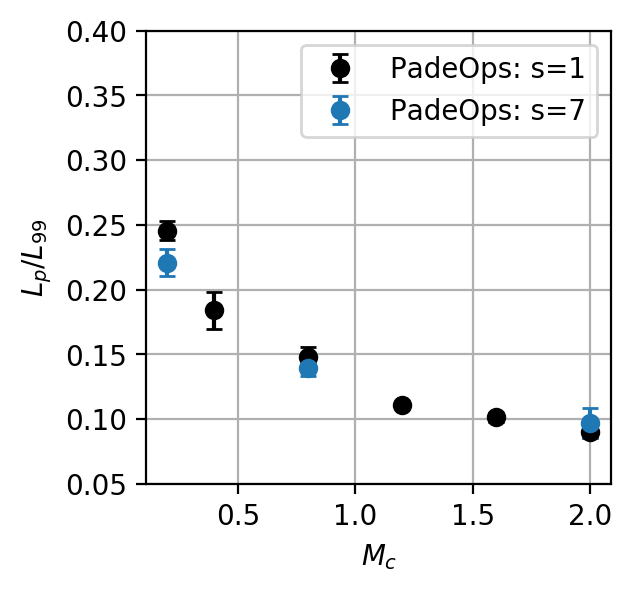

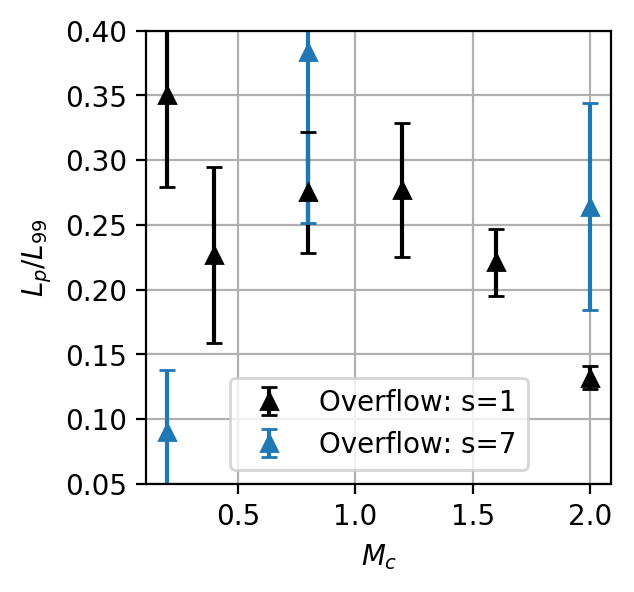

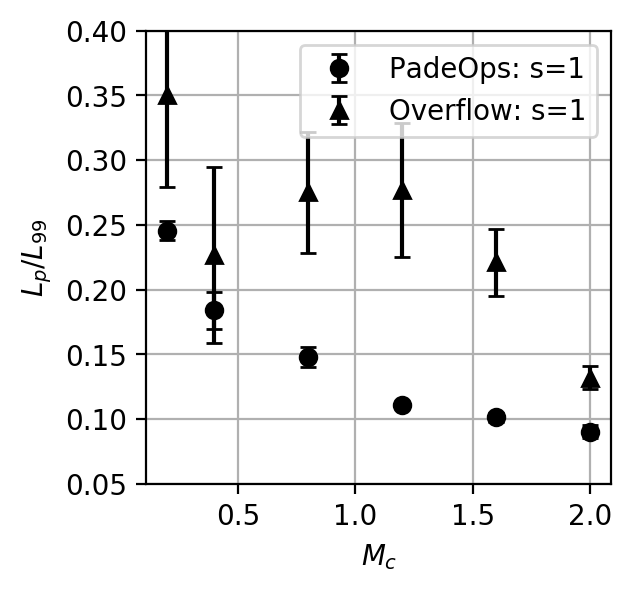

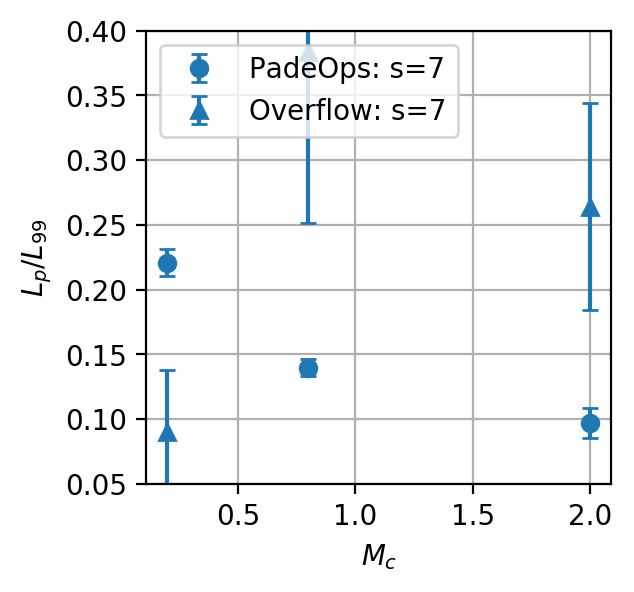

In [11]:
#OVERFLOW
    
Lvv_ovf = {
    0.2: [0.350, 0.071],
    0.4: [0.227, 0.068],
    0.8: [0.275, 0.047],
    1.2: [0.277, 0.052],
    1.6: [0.221, 0.026],
    2.0: [0.132, 0.009] }

Lvv_rr_7_ovf = {
    0.2: [0.083, 0.023],
    0.8: [0.333, 0.073],
    2.0: [0.342, 0.078] 
}

Lvv_rr7_ovf = {
    0.2: [0.097, 0.042],
    0.8: [0.434, 0.110],
    2.0: [0.186, 0.018] 
}

rr_ovf = merge_dicts(Lvv_rr7_ovf,Lvv_rr_7_ovf)

def make_nice():
    plt.legend()
    plt.grid(True)
    plt.xlabel(r'$M_c$')
    plt.ylabel(r'$L_p/L_{99}$')
    plt.ylim([0.05,0.4])

DPI=200 
prefix = '/home/kmatsuno/Ovf_compare/Lp_'

fig = plt.figure(figsize=(3,3),dpi=DPI)
plt.errorbar(Lvv.keys(),[x[0] for x in Lvv.values()], yerr=[x[1] for x in Lvv.values()],fmt='ko',label='PadeOps: s=1',capsize=3)
# plt.errorbar(Lvv_rr_7.keys(),[x[0] for x in Lvv_rr_7.values()],yerr=[x[1] for x in Lvv_rr_7.values()],fmt='o',label='PadeOps: s=1/7',color='C0',capsize=3)
# plt.errorbar(Lvv_rr7.keys(),[x[0] for x in Lvv_rr7.values()], yerr=[x[1] for x in Lvv_rr7.values()],fmt='o',label='PadeOps: s=7',color='C1',capsize=3)
plt.errorbar(rr.keys(),[x[0] for x in rr.values()], yerr=[x[1] for x in rr.values()],fmt='o',label='PadeOps: s=7',capsize=3)
make_nice()
plt.savefig(prefix+'padeops.png',dpi=DPI, bbox_inches='tight')

fig = plt.figure(figsize=(3,3),dpi=DPI)
plt.errorbar(Lvv_ovf.keys(),[x[0] for x in Lvv_ovf.values()],yerr=[x[1] for x in Lvv_ovf.values()],fmt='k^',label='Overflow: s=1',capsize=3)
# plt.errorbar(Lvv_rr_7_ovf.keys(),[x[0] for x in Lvv_rr_7_ovf.values()], yerr=[x[1] for x in Lvv_rr_7_ovf.values()],fmt='^',color='C0',label='Overflow: s=1/7',capsize=3)
# plt.errorbar(Lvv_rr7_ovf.keys(),[x[0] for x in Lvv_rr7_ovf.values()], yerr=[x[1] for x in Lvv_rr7_ovf.values()],fmt='^',color='C1',label='Overflow: s=7',capsize=3)
plt.errorbar(rr_ovf.keys(),[x[0] for x in rr_ovf.values()], yerr=[x[1] for x in rr_ovf.values()],fmt='^',label='Overflow: s=7',capsize=3)
make_nice()
plt.savefig(prefix+'ovf.png',dpi=DPI, bbox_inches='tight')

fig = plt.figure(figsize=(3,3),dpi=DPI)
plt.errorbar(Lvv.keys(),[x[0] for x in Lvv.values()], yerr=[x[1] for x in Lvv.values()],fmt='ko',label='PadeOps: s=1',capsize=3)
plt.errorbar(Lvv_ovf.keys(),[x[0] for x in Lvv_ovf.values()],yerr=[x[1] for x in Lvv_ovf.values()],fmt='k^',label='Overflow: s=1',capsize=3)
make_nice()
plt.savefig(prefix+'rr1.png',dpi=DPI, bbox_inches='tight')

fig = plt.figure(figsize=(3,3),dpi=DPI)
plt.errorbar(rr.keys(),[x[0] for x in rr.values()],yerr=[x[1] for x in rr.values()],fmt='o',label='PadeOps: s=7',color='C0',capsize=3)
plt.errorbar(rr_ovf.keys(),[x[0] for x in rr_ovf.values()], yerr=[x[1] for x in rr_ovf.values()],fmt='^',color='C0',label='Overflow: s=7',capsize=3)
make_nice()
plt.savefig(prefix+'rr7.png',dpi=DPI, bbox_inches='tight')

